### Mission Statement
For this demo, I will play the role of a data scientist tasked with allocating Quora's manual review resources effectively.

I will be using the Quora insincere question dataset. There are 1.3M questions in this dataset, each labeled sincere or insincere. An insincere question is generally meant to be inflammatory and does not seek genuine answers, rather it is meant to imply something about a group of people.

For simplicity of this demo, I make the following assumptions:
* Insincere is the only quality used by manual reviewers to flag and remove questions
* All insincere questions are equally bad
* The manual review team is a perfect labeler of sincere/insincere
* The training (and validation) data is an accurate representation of what new questions will look like
* Quora's manual review team has the capacity to properly evaluate 8% of all incoming questions for this task
* Quora would generally prefer to remove a sincere question rather than allow an insincere question to be posted
    * A missed detection (approved insincere question) is 3x as bad as a false positive (automatically removed sincere question)

My goal as a data scientist on this project is to take all incoming questions and divide them between 3 streams: automatically removed, manual review, and automatically approved.

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_recall_curve
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import datasets
import torch
from torch import nn, tensor

# Define the data directories
DATA_DIR = "./data/quora_insincere_questions" # input data directory
CP_DIR = "./models/Quora" # checkpoint directory
os.makedirs(CP_DIR, exist_ok=True) # Make the checkpoint directory if it doesn't exist

# Disable the progress bars
datasets.disable_progress_bar()

# Other global definitions
EDA = True # Do you want to run the exploratory data analysis?
EVAL_BATCH_SIZE = 128
MAX_MANUAL_REVIEW = 0.08 # Percent that can be manually reviewed
FP_TO_FN_COST_RATIO = 3 # False Negatives are 3x as bad as False Positives

### Dataset
The dataset has 1.3M samples in the training set. The actual dataset (from Kaggle) comes with a test set as well, but the labels for the test set are not published.

This demo is to demonstrate NLP and ML techniques, to simulate conversations with stakeholders, and to simulate a real-world scenario where I am tasked with allocating the manual reviewer's time efficiently. Since this is a demo and not intended to produce an output for the competition, I will be ignoring the published test set. I will be withholding 10% of the training data (~130k samples) as my own test data. The test data represents 'new' production data. The simulated production data is a measure of how well I have done to allocate our manual reviewer's time and how well I have done in removing insincere questions while allowing sincere questions.

In [2]:
# Dataset for this notebook is the Quora Insincere Questions classification dataset
# It contains ~1.3M training samples. Each sample is a question and a binary sincere/insincere label
# The data is from a Kaggle competition, and more information as well as the data download can be found here:
# https://www.kaggle.com/c/quora-insincere-questions-classification/overview
label2class = {"Sincere": 0, "Insincere": 1}
labeled_data = pd.read_csv(os.path.join(DATA_DIR, "train.csv")).rename(columns={"target":"label"})

# I split the labeled data into train and test myself for this demo
# The test_data will be used as our ground truth data and represents 'new' production data
# The "full data" available for training and validation contains ~1.17M samples
test_data = labeled_data.sample(frac=0.1, random_state=42)
trainval = labeled_data.drop(test_data.index)
del labeled_data
test_data = datasets.Dataset.from_pandas(test_data)

### Exploratory Data Analysis, Tokenization, Utils
**Data Cleaning**

This data is incredibly clean. Granted, it is only 2 fields: the question and label. So there isn't anything really to 'clean'. 
There is a class imbalance - only 6% of samples as insincere. I'll assume this is representative of the actual incoming stream of questions to Quora for the demo. (In reality, outside of my demo, it is likely oversampled and has an even higher proportion of insincere questions than the actual raw incoming stream)
<br><br>

**Tokenization**

I have to set some upper bound on for the max tokenized sequence length. Ideally, I would set the bound based on the max character length allowed in Quora, and the corresponding max token length for a coherent question.
That doesn't work for a few reasons:
* I'm running this demo on my personal machine and am limited in resources to my single 3060 GPU. Longer sequence lengths mean higher memory requirements, longer training, etc.
* Allowing samples from the tail of the distribution of lengths would likely need more representative training data.
    * In the ~1.17M samples of training/validation data, only 8 samples (< 0.001%) longer than 150 tokens. There are 44 (< 0.004%) longer than 100 tokens, and 682 (~0.06%) longer than 64 tokens.
    * An arbitrarily long sequence length might lead to undefined model behavior.
        * For example, if the sincere-ness of a sample is independent of the sequence length, there is a 5.7% change that you could randomly sample 44 samples and see only sincere samples. This is the same number of samples we have longer than 100 tokens. The model might then incorrectly learn that all samples longer than 100 tokens are always sincere.

We are assuming the samples will be representative of new data, so I can use the training data to determine our max token length
* ~0.06% of samples are longer than 64 tokens. So I don't mind truncating down to 64 tokens
* ~0.7% are between 50 and 64 tokens (inclusive). So truncating to less than 50 begins to lose information
* 64 seems like a nice round power of 2 for a demo

I chose 64 tokens, but I would definitely run this by stakeholders before sending it to production
* For one, this means an easy attack vector for a malicious actor is to have the first 64 tokens worth of their question be sincere, then they can be as insincere as they want for the remainder of the question and the model wouldn't know.

A simple solution for handling long questions would be to send all of them to the manual review team. That would eat up ~0.06% of their 8% capacity leaving us with ~7.94% for all other samples. For this demo I continue as if we have the full 8% to work with, but that would be a viable option at least for the initial release.
* This is still an attack vector because if we start to get a large number of long questions it will overwhelm the manual review team
* Over time, as the manual review team labels those long samples we would end up with an additional dataset of long questions. We could either increase the token length and train one model on all data, or we could train a secondary model on only long samples. I explore a similar concept in the "Where would we go from here?" section.
<br><br>

**Utils**

model_costs: This function has several parts:
* Given the predictions from the model, we can get the "insincereness" score between 0 and 1 from the model for each question.
* Since we have 3 processes: automated removal, manual review, and automatic approval. We have 2 thresholds: automatic and flagging. A score greater than the automatic threshold means that question is automatically removed. A score greater than the flagging threshold but less than the automated threshold means that question is manual reviewed. Since our manual review resource is limited, the automatic threshold is a function of the flagging threshold. The algorithm to determine the automatic threshold is as follows: get all samples with a score above the flagging threshold. If the number of samples is greater than the amount that can be handled by the manual reviewers, automatically remove the highest scoring sample. Continue automatically removing the highest scoring samples until the number of remaining samples is able to be handled by the manual reviewers. Anything with a score less than the flagging threshold is automatically approved.
* We can construct a cost function given our assumption that "A missed detection (approved insincere question) is 3x as bad as a false positive (automatically removed sincere question)". 
* We then need to count the number of sincere questions automatically removed and the number of insincere questions automatically approved. We do a weighted sum of those two with approved insincere questions being weighted 3x as much as removed sincere questions. We then divide by the total number of questions to get the average cost. A higher cost is bad. An oracle that could remove all insincere questions while approving all sincere would have an average cost of 0. For reference, sending a random selection of 8% of all questions to the manual reviewers and allowing all other questions results in an average cost of ~0.171.
* We return 4 lists by default: flagging_threshs, costs, false_positive_rates, and false_negative_rates. flagging_threshs[i], costs[i], false_positive_rates[i], and false_negative_rates[i] are all associated with each other. So you could plot threshs vs costs, false_positive_rates vs false_negative_rates, etc.
* Alternatively, you can set the get_thresholds_only input to True and it will return the optimal flagging threshold and associated optimal automatic threshold. Optimal is defined as lowest cost.

min_model_cost: A wrapper around model_costs that returns the minimum cost.

compute_metrics: We want to report several metrics on the validation data during training - the accuracy, F1, and cost. Calculating the cost allows us to define the "best" model to be the one that minimizes our cost function. The other metrics are good to keep an eye on during training as they can indicate overfitting, bugs, and other bad behaviors. Accuracy is not as great of a metric since the dataset is so imbalanced, but it can be useful to report.

get_weighted_loss_func: Given the class weightings, returns a weighted cross-entropy loss function that has that weighting. Used to create the function to be passed to Trainer as compute_loss_func. Note: The value passed here shouldn't necessarily be based on the class imbalance in the input distribution. After some experimentation, I found it achieved a slightly lower average cost using a 3:1 weighting. This is likely because our stakeholders have told us that a missed detection is 3x as bad as a false positive.

In [3]:
# This data is extremely clean. There are no NaNs in any of the fields
if EDA:
    print(trainval.isna().sum())

qid              0
question_text    0
label            0
dtype: int64


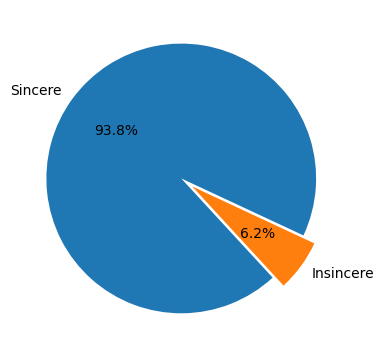

In [4]:
# There is a class imbalance: 93.8% of the data is sincere, and only 6.2% is insincere
if EDA:
    counts = pd.DataFrame(trainval["label"]).value_counts().to_numpy()
    class_proportions = counts / sum(counts)
    plt.figure(figsize=(4, 4))
    plt.pie(class_proportions, labels=label2class.keys(), explode=(0, 0.1), autopct="%1.1f%%", startangle=-25)
    plt.tight_layout()
    plt.show()

In [ ]:
# First, we want to determine a token length for our input sequences
# We can tokenize the dataset (without padding or truncation) to get the lengths
if EDA:
    tokenizer_prelim = AutoTokenizer.from_pretrained("roberta-base")
    def tokenize_prelim(batch):
        return tokenizer_prelim(batch["question_text"])
    trainval_prelim = datasets.Dataset.from_pandas(trainval).map(tokenize_prelim, batched=True)

    def get_length(batch):
        return {"length": len(batch["input_ids"])}
    lengths = trainval_prelim.map(get_length, batched=False)["length"]

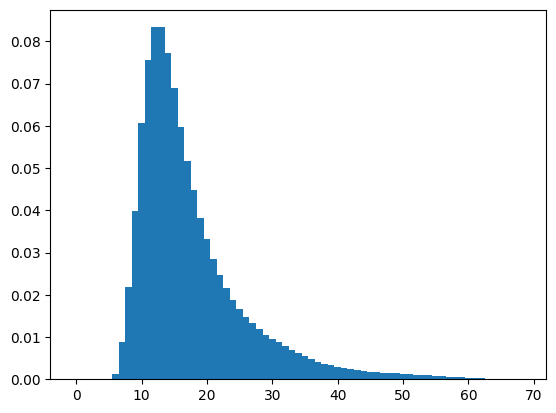

Percentage longer than 64: 0.06
Average number of tokens: 17.64


In [6]:
# ~0.03% of the Quora questions are longer than 70 tokens
# I've removed them from the histogram of the token lengths so the histogram is more readable
#   If we don't remove them, the x-axis goes to >500 and becomes too squished
# Each bar in the histogram has a width 1 and is centered on an integer
if EDA:
    plt.hist(
        [x for x in lengths],
        bins=np.arange(70) - 0.5,
        density=True
    )
    plt.show()

    # I selected a max sequence length of 64
    # This is partially so that it is relatively short for my personal GPU
    # It is also a good trade off where >99.9% of the data is still less than the max_length
    print("Percentage longer than 64:", np.round(sum(1 for x in lengths if x > 64) / len(lengths) * 100, 2))
    print("Average number of tokens:", np.round(np.mean(lengths), 2))

In [7]:
# These EDA items are quite large, and we can remove them from memory
if EDA:
    del trainval_prelim
    del lengths
    del tokenizer_prelim

In [8]:
def model_costs(labels, preds, get_thresholds_only=False):
    """ Finds the optimal thresholds to flag and automatically remove questions based on minimizing the cost function """
    def cost_function(precs, recalls, flagged_index, percent_insincere):
        """ Given the threshold to use (indirectly via flagged_index), find the cost of operating at that threshold """
        # Precision, and Recall for all flagged samples (some will be manually reviewed, others automatically removed)
        prec_flagged, recall_flagged = precs[flagged_index], recalls[flagged_index],

        # Calculate the false negative rate (missed detection rate)
        prop_insincere_and_flagged = recall_flagged * percent_insincere
        
        if prec_flagged > 0.0:
            prop_all_samples_flagged = prop_insincere_and_flagged / prec_flagged
        else:
            prop_all_samples_flagged = 0.0

        prop_insincere_and_not_flagged = percent_insincere - prop_insincere_and_flagged
        false_negative_rate = prop_insincere_and_not_flagged / percent_insincere

        # Based on the total number of samples we want flagged and the amount of manual resources we have, find the
        #   minimum number of samples that need to be automatically removed
        # Takes advantage of recalls being sorted and precs being reverse sorted
        auto_remove_index = -1
        low = flagged_index
        high = len(recalls) - 1
        while low <= high:
            mid = (low + high) // 2
            prec_auto, recall_auto = precs[mid], recalls[mid]
            prop_insincere_and_auto_removed = recall_auto * percent_insincere
            
            if prec_auto > 0.0:
                prop_samples_and_auto_removed = prop_insincere_and_auto_removed / prec_auto
            else:
                prop_samples_and_auto_removed = 0.0
            
            prop_manually_reviewed = prop_all_samples_flagged - prop_samples_and_auto_removed

            if prop_manually_reviewed < MAX_MANUAL_REVIEW:
                auto_remove_index = mid
                low = mid + 1 
            else:
                high = mid - 1

        prec_auto, recall_auto = precs[auto_remove_index], recalls[auto_remove_index]
        prop_insincere_and_auto_removed = recall_auto * percent_insincere
        if prec_auto > 0.0:
            prop_samples_and_auto_removed = prop_insincere_and_auto_removed / prec_auto
        else:
            prop_samples_and_auto_removed = 0.0
        prop_manually_reviewed = prop_all_samples_flagged - prop_samples_and_auto_removed

        # Calculate the false positive rate (sincere questions that get auto-removed)
        prop_sincere_and_auto_removed = prop_samples_and_auto_removed - prop_insincere_and_auto_removed
        false_positive_rate = prop_sincere_and_auto_removed / (1-percent_insincere)

        # Unflagged insincere questions are 3x as bad as auto removed sincere questions
        cost = prop_sincere_and_auto_removed + FP_TO_FN_COST_RATIO*prop_insincere_and_not_flagged
        return cost, (false_positive_rate, false_negative_rate), auto_remove_index

    pred_insincere = nn.functional.softmax(torch.tensor(preds), dim=1)[:, 1]
    percent_insincere = np.count_nonzero(labels) / len(labels)
    precs, recalls, threshs = precision_recall_curve(labels, pred_insincere)

    costs, props_failures, auto_remove_indices = [], [], []
    for i in range(len(threshs)):
        cost, props_failure, auto_remove_idx = cost_function(precs, recalls, i, percent_insincere)
        costs.append(cost)
        props_failures.append(props_failure)
        auto_remove_indices.append(auto_remove_idx)

    props_failures = np.array(props_failures)
    false_positive_rates = props_failures[:, 0]
    false_negative_rates = props_failures[:, 1]

    if get_thresholds_only:
        min_cos_idx = np.argmin(costs)
        opt_flagging_threshold = threshs[min_cos_idx]
        opt_auto_remove_idx = auto_remove_indices[min_cos_idx]
        opt_automatic_threshold = threshs[opt_auto_remove_idx]
        return opt_flagging_threshold, opt_automatic_threshold

    else:
        return threshs, costs, false_positive_rates, false_negative_rates

def min_model_cost(labels, preds):
    """ Calculates the (minimum) cost for the output of the model """
    __, costs, __, __ = model_costs(labels, preds)
    return np.min(costs)

In [9]:
def compute_metrics(eval_pred):
    """ Function that will be used to compute metrics at evaluation """
    logits, labels = eval_pred
    cost = min_model_cost(labels, logits)
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions)
    accuracy = accuracy_score(labels, predictions)
    return {"eval_f1": f1, "eval_accuracy": accuracy, "eval_cost": cost}

In [10]:
def get_weighted_loss_func(class_weights):
    """ Creates a weighted cross-entropy loss function """
    def compute_weighted_loss_func(outputs, labels, num_items_in_batch=None):
        logits = outputs.logits

        # Calculate the loss using class weights
        loss_fct = nn.CrossEntropyLoss(weight=tensor(class_weights, device=logits.device).float())
        loss = loss_fct(logits, labels)

        return loss
    return compute_weighted_loss_func


### Training
* The data available for training and validation has 1.17M samples. We reserve 10% of the data for validation. 1.05M are used as training data and the remaining 117k are used as validation data.
* For this example, I'm using RoBERTa for my embedding model. RoBERTa made several improvements on BERT, training longer and with more data as well as some improvements to the pre-training that boosted performance.
    * If less data was available, a smaller model such as DistilBERT or ALBERT might be a better choice since they might be less prone to overfitting on the smaller dataset
* With 1.17M samples, it is relatively easy to achieve performance and be confident that our validation data is representative of the test data
    * Since we have a large dataset, there was no need for advanced techniques like oversampling the underrepresented class or data augmentation
        * When the dataset is not so large, it is common to perform data augmentation using synonym replacement or back translation. Even if the dataset as a whole is large enough, data augmentation can be used to fix a class imbalance by generating synthetic samples of an underrepresented class.
* I did a mild amount of hyperparameter tuning and evaluated each iteration on the validation data only (no test data)
* Most combinations of hyperparameters in the search space around the chosen parameters produce a similar F1 score and cost. Based on that we can be fairly confident this is about as good as it's going to get without a significant overhaul such as a better model, better regularization, data augmentation, etc.
    * I include a mild amount of dropout for regularization. Dropout helps reduce overfitting by randomly setting certain activations to 0. This means the model cannot become highly dependent on any single feature or small set of features because they may not always be available. This helps with overfitting because the model must learn a more generalized set of features. This is especially useful when deploying a model to production if a relatively long time has passed between when the training data was collected and when the model is deployed. It would be bad if the model was highly dependent on a small set of features that are no longer present because the distribution of data has shifted. A similar idea is explored in the "Model Selection Continued" section.

Note: We can "cheat" and look at the leaderboards from the Kaggle competition. We obviously couldn't do this if it was an internal project. At any rate, the best model on the leaderboards had an F1 score of 71.3%. On the validation data our maximum F1 score was 72.7%. That may be because the test data in the competition was harder, but we may have legitimately outperformed the top model. That may seem odd because we did so while withholding 10% of the data from training to keep as simulated production data for later. But this isn't surprising considering the competition disallowed BERT and BERT-like models, which are SOTA for this type of problem.

In [11]:
# Hyperparameters when using the
MODEL_ID = "roberta-base"
MAX_LENGTH = 64
BATCH_SIZE = 128
WARMUP_RATIO = 0.10
NUM_EPOCHS = 3
EVAL_STEPS = 1000
HIDDEN_DROPOUT = 0.1
ATTENTION_DROPOUT = 0.1
LEARNING_RATE = 2e-5

# Set the class weights such that approved insincere samples are weighted 3x as much as removed sincere samples
#   Same as our cost function
class_weights= [1, FP_TO_FN_COST_RATIO]
class_weights /= np.linalg.norm(class_weights)

# Create a folder to save all the checkpoints
os.makedirs(CP_DIR, exist_ok=True)

In [12]:
# Split the training and validation data into two datasets
trainval = datasets.Dataset.from_pandas(trainval).train_test_split(test_size=0.1, seed=42)
trainval["validation"] = trainval.pop("test")

In [ ]:
# Tokenize the dataset
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
def tokenize(batch):
    return tokenizer(
        batch["question_text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )
trainval = trainval.map(tokenize, batched=True)

In [14]:
# For the first batch of training, the default model configuration parameters will work fine
model_config = AutoConfig.from_pretrained(MODEL_ID)
model_config.classifier_dropout = HIDDEN_DROPOUT
model_config.hidden_dropout_prob = HIDDEN_DROPOUT
model_config.attention_probs_dropout_prob = ATTENTION_DROPOUT
model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, config=model_config)

In [15]:
# Set the training arguments
training_args = TrainingArguments(
    output_dir=CP_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    optim="adamw_torch_fused",
    logging_strategy="steps",
    logging_steps=EVAL_STEPS/10,
    eval_strategy="steps",
    eval_steps=EVAL_STEPS,
    save_strategy="steps",
    save_steps=EVAL_STEPS,
    metric_for_best_model="eval_cost",
    greater_is_better=False,
    load_best_model_at_end=True,
    learning_rate=LEARNING_RATE,
    lr_scheduler_type="cosine",
    warmup_ratio=WARMUP_RATIO,
)

# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainval["train"],
    eval_dataset=trainval["validation"],
    compute_metrics=compute_metrics,
    compute_loss_func=get_weighted_loss_func(class_weights)
)

In [16]:
trainer.train()

Step,Training Loss,Validation Loss,F1,Accuracy,Cost
1000,0.188800,0.170108,0.650476,0.945641,0.030880
2000,0.172400,0.169571,0.666965,0.949299,0.028005
3000,0.166500,0.164885,0.676639,0.952923,0.027248
4000,0.171100,0.158143,0.703895,0.961523,0.024704
5000,0.151400,0.162949,0.696988,0.957040,0.025487
6000,0.156300,0.159828,0.714890,0.962748,0.022986
7000,0.160900,0.146230,0.697597,0.955364,0.022076
8000,0.152400,0.152254,0.694533,0.954369,0.021880
9000,0.137600,0.159372,0.715854,0.962127,0.021922
10000,0.134100,0.158717,0.721624,0.963259,0.021727


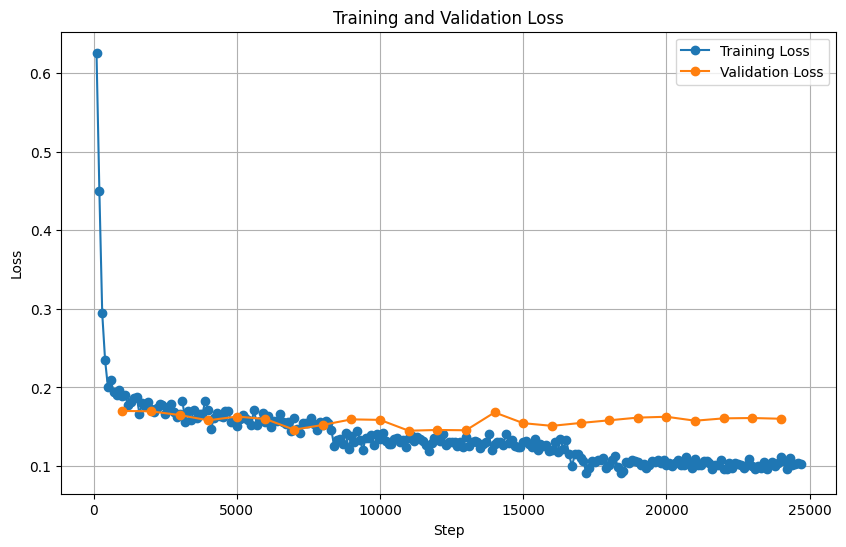

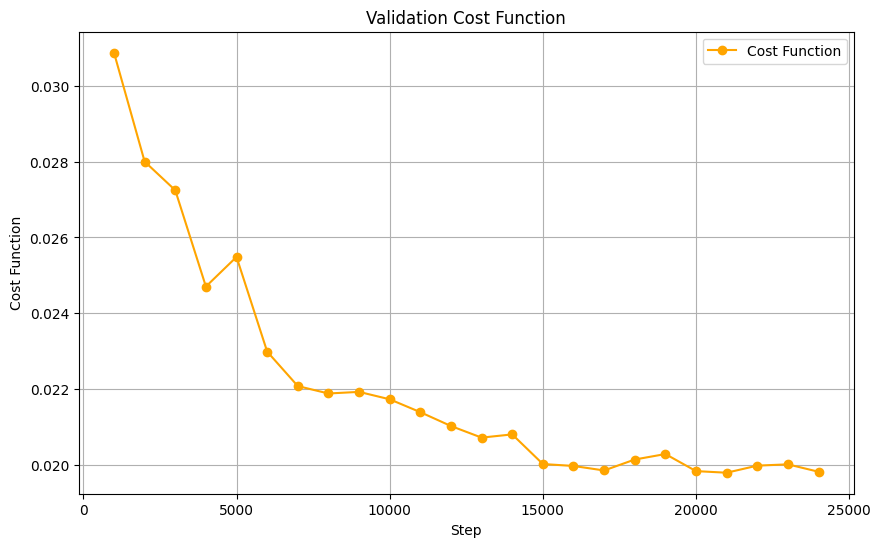

In [17]:
# Plot the training and validation history
logs = trainer.state.log_history
log_df = pd.DataFrame(logs)
log_df = log_df[log_df["step"].notna()]
valid_eval_df = log_df.dropna(subset=["eval_loss"])

plt.figure(figsize=(10, 6))
plt.plot(log_df["step"], log_df["loss"], label="Training Loss", marker="o")
plt.plot(valid_eval_df["step"], valid_eval_df["eval_loss"], label="Validation Loss", marker="o")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(valid_eval_df["step"], valid_eval_df["eval_cost"], label="Cost Function", marker="o", color="orange")
plt.xlabel("Step")
plt.ylabel("Cost Function")
plt.title("Validation Cost Function")
plt.legend()
plt.grid()
plt.show()

### Model Selection

For detection problems like this, stakeholders will often say something like "we want to remove as many insincere questions as possible while removing as few sincere questions as possible". Fortunately or unfortunately, there is a continuum of points that the model can operate on as shown by the Detection Error Tradeoff Curve. That is why I made an assumption that "A missed detection (approved insincere question) is 3x as bad as a false positive (removed sincere question)". Usually, after talking with stakeholders we can come to some kind of agreement like that and then build a cost function around that agreement.

We can and should optimize based on cost function, but we shouldn't necessarily blindly declare the model with the minimum cost function is the best model. After 15k iterations, the cost function is effectively constant plus/minus some noise. Technically, the model with the minimum cost occurred at iteration 21k. However, this was only ~1% better than at 15k iterations. Since our cost function effectively counts the number of approved insincere and removed sincere, it is not a continuous function like cross-entropy. Really, our cost function uses the model as a ranking function, and the score assigned by the model could change without changing the cost. Ex: If we applied the function f(x) = x / (x + 1) to the insincereness scores from the model, the scores would all be lower but the minimum model cost would be the same since the new function preserves orderings.

We can plot some visualizations of the performance of all models and see if anything jumps out. The two plots shown are the Detection-Error Tradeoff (DET) and the cost-flagging-threshold curve.

DET plots the missed detection rate on the y-axis and the false positive rate on the x-axis. These are the approved insincere and removed sincere questions respectively. A missed detection rate of 10% means we removed 90% of the insincere questions. A false positive rate of 0.5% means we remove 0.5% of the sincere questions. On a DET plot, the bottom left corner represents perfect performance (no missed detections, no false positives).

The other plot is a custom plot: the cost vs flagging-threshold plot. It is analogous to an F1 vs decision threshold plot. See the "Exploratory Data Analysis, Tokenization, Utils" section, specifically model_costs for a breakdown on how the cost function is calculated and why it is a function of the flagging threshold (but not the automatic threshold). For relatively low thresholds, we remove too many sincere questions. For relatively high thresholds, we approve too many insincere samples. There is a minimum somewhere in between. Lower is better on the cost vs flagging-threshold curve.

The plot with all models is messy. It should hopefully be evident that models taken before iteration 15k are greatly output performed all the later models. It may not be as evident, but it is also the case that models after iteration 21k have essentially identical performance. For similar reasons, we can remove all but the 16k and 21k iteration models. A discussion with those two models is given in the "Model Selection Continued" section.

In [18]:
# Get the validation performance for all checkpoints

# Get the paths to the models we are going to compare
paths = glob.glob(os.path.join(CP_DIR, "*"))
paths = sorted([(int(path.split("-")[-1]), path) for path in paths if path.split("-")[-1].isnumeric()])
paths = [path[1] for path in paths]

# Get the ground truth labels
val_y_true = trainval["validation"]["label"]

# Run all relevant models and plot the results
threshs, costs, false_positive_rates, false_negative_rates = [], [], [], []
for path in paths:
    model = AutoModelForSequenceClassification.from_pretrained(path)
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=trainval["train"],
        eval_dataset=trainval["validation"]
    )
    
    # Get the Validation Predictions
    val_y_pred = trainer.predict(trainval["validation"]).predictions

    # Run the helper function
    thresh, cost, false_positive_rate, false_negative_rate = model_costs(val_y_true, val_y_pred)

    threshs.append(thresh)
    costs.append(cost)
    false_positive_rates.append(false_positive_rate)
    false_negative_rates.append(false_negative_rate)

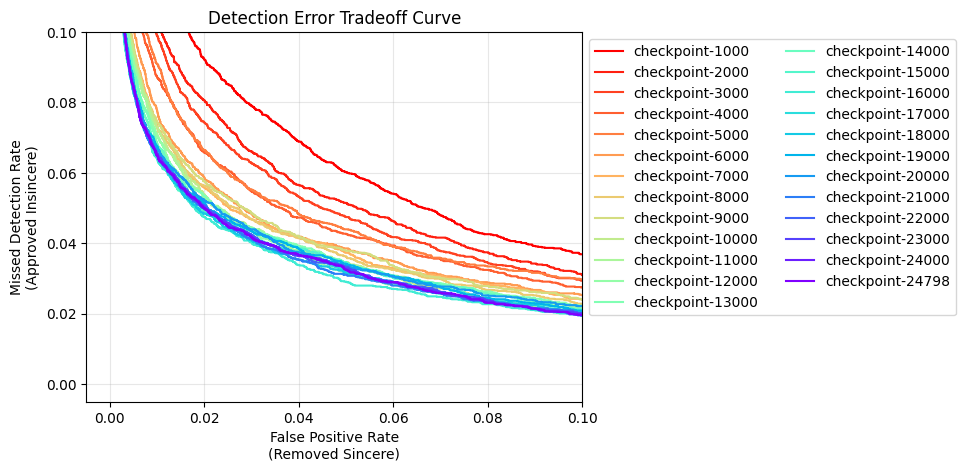

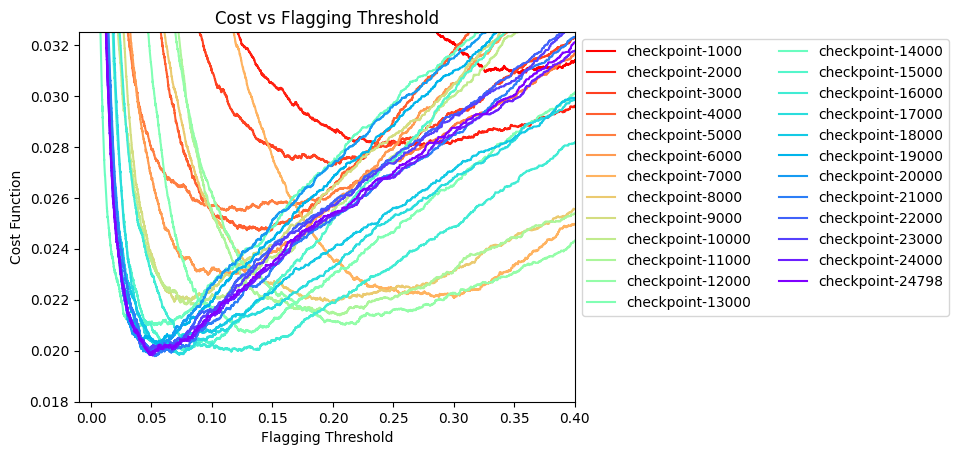

In [19]:
# Plot the DET and cost-threshold plots for all models
det = plt.figure("det")
cost_v_thresh = plt.figure("cost_v_thresh")

colors = cm.rainbow(np.linspace(1, 0, len(paths)))
for i in range(len(paths)):
    path, color = paths[i], colors[i]
    thresh, cost = threshs[i], costs[i]

    false_positive_rate, false_negative_rate = false_positive_rates[i], false_negative_rates[i]
    plt.figure("det")
    plt.plot(false_positive_rate, false_negative_rate, color=color, label=path.split(os.sep)[-1])
    plt.figure("cost_v_thresh")
    plt.plot(thresh, cost, label=path.split(os.sep)[-1], color=color)

plt.figure("det")
plt.grid(alpha=0.3)
plt.xticks(np.linspace(0, 0.10, 6))
plt.yticks(np.linspace(0, 0.10, 6))
plt.xlim(-0.005, 0.10)
plt.ylim(-0.005, 0.10)
plt.title("Detection Error Tradeoff Curve")
plt.xlabel("False Positive Rate\n(Removed Sincere)")
plt.ylabel("Missed Detection Rate\n(Approved Insincere)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=2)

plt.figure("cost_v_thresh")
plt.title("Cost vs Flagging Threshold")
plt.xlim(-0.01, 0.4)
plt.ylim(0.018, 0.0325)
plt.xlabel("Flagging Threshold")
plt.ylabel("Cost Function")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=2)

plt.show()

### Model Selection Continued

After removing all the chaff, we are left with 2 models: 16k and 21k with cost minimum of 0.0200 and 0.0198 respectively (a 1% difference). The 21k model is the best model because it has the lowest cost, but the visualizations show more nuance.

Looking at the DET plot, the 16k model outperforms the 21k model when the false positive rate is greater than 1%. Notably, the lowest cost point for both models is when the false positive rate is ~0.5% and the missed detection rate is ~8%. When the false positive rate is around 0.5%, it looks like the 21k model outperforms the 16k model just barely.

Before looking at the cost vs flagging-threshold plot, we should consider that this exercise assumes we are deploying this model in production to users. User's language changes over time, so we expect the distribution of questions to shift as well - new user base with different word choice, new slang words that come and go, words that existed but are now used more frequently, etc. [According to Oxford University Press](https://languages.oup.com/) (publisher of the Oxford English Dictionary) words the word "vaccine" saw a spike in usage in 2021 (related to the Covid Vaccine), "metaverse" in 2022 (related to Meta's virtual reality), and "prompt" in 2023 (related to LLMs). The dataset used for this analysis was published in 2018 and includes the words vaccine and prompt, but our data wouldn't include questions related to Covid or LLMs. The dataset does not contain the word "metaverse". The change in input distribution can cause a change in distribution to the model's output. Maybe the new slang and new distribution of words causes the model to increase or decrease the insincereness score of all samples by 0.02 (ignoring edge cases where the score would then no longer be bounded by 0 and 1). The "best" model might be one that has slightly lower performance, but which we expect to be more robust to a shift to the input distribution.

Looking at the cost vs flagging-threshold plot, we see that the minimum of the 21k model is in fact the lowest, but the local minima is relatively steep. If the insincereness scores all increased or decreased by 0.02, the cost would increase up to 0.0218 (an 10% increase). Conversely, the region around the minimum of the 16k model is relatively flat. If the insincere scores all increased or decreased by 0.02, the cost would only increase up to 0.0202 (a 1.6% increase). So in this regard, the 16k model is more robust to this kind of change. This is a massively oversimplified example of what a change in the output distribution might look like, but it demonstrates the point.

Ideally, we would continuously update the model using newly labeled data from the manual review team. This would mean we don't need to worry as much about the robustness of the model to shifts because we would be updating the model as the distribution shift. This is elaborated upon in "Where would we go from here?"

For the remainder of the notebook, I will be using the 16k model. The choice of model ultimately becomes a discussion with stakeholders. If the stakeholders expect this project to be continually staffed and monitored, and we expect to make updates to the model several times a year, in general it may be preferred to use a higher performing but less robust model. However, at the initial release it would likely be good idea to use the slightly lower performing but more robust model while we iron out other details and get other processes up and running.

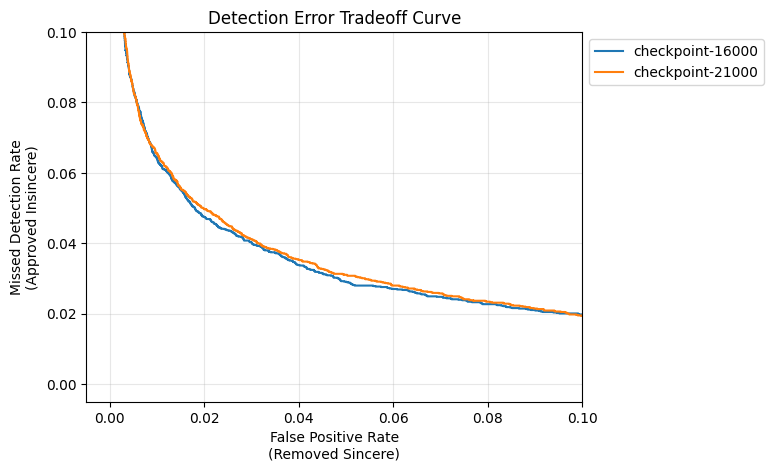

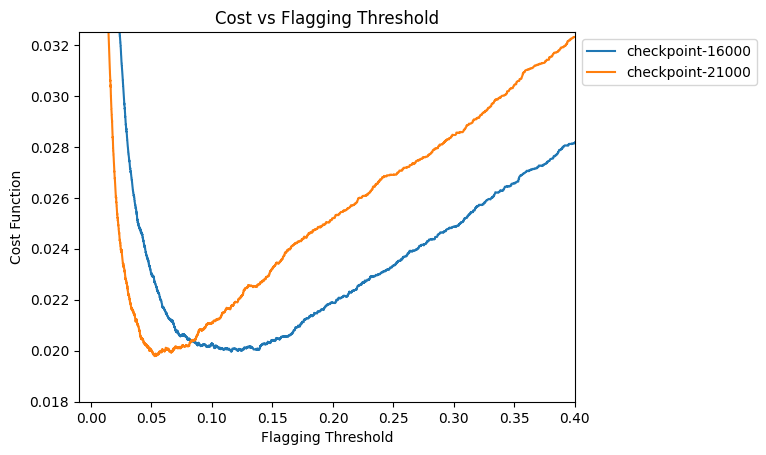

In [20]:
# Plot the DET and cost-threshold plots for the models of interest
det = plt.figure("det")
cost_v_thresh = plt.figure("cost_v_thresh")

models_of_interest = [15, 20]
for i, path in enumerate(paths):
    if i not in models_of_interest:
        continue
    thresh, cost = threshs[i], costs[i]
    false_positive_rate, false_negative_rate = false_positive_rates[i], false_negative_rates[i]
    plt.figure("det")
    plt.plot(false_positive_rate, false_negative_rate, label=path.split(os.sep)[-1])
    plt.figure("cost_v_thresh")
    plt.plot(thresh, cost, label=path.split(os.sep)[-1])

plt.figure("det")
plt.grid(alpha=0.3)
plt.xticks(np.linspace(0, 0.10, 6))
plt.yticks(np.linspace(0, 0.10, 6))
plt.xlim(-0.005, 0.10)
plt.ylim(-0.005, 0.10)
plt.title("Detection Error Tradeoff Curve")
plt.xlabel("False Positive Rate\n(Removed Sincere)")
plt.ylabel("Missed Detection Rate\n(Approved Insincere)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.figure("cost_v_thresh")
plt.title("Cost vs Flagging Threshold")
plt.xlim(-0.01, 0.4)
plt.ylim(0.018, 0.0325)
plt.xlabel("Flagging Threshold")
plt.ylabel("Cost Function")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

In [21]:
# Set the model to the selected model
model = AutoModelForSequenceClassification.from_pretrained(os.path.join(CP_DIR, "checkpoint-16000"))
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainval["train"],
    eval_dataset=trainval["validation"]
)

#### Validation Performance
On the validation data, using the combination of 8% manual review and automatic removal, we are able to reduce the number of insincere questions by ~92% while only removing ~0.56% of sincere questions.

We have intentionally avoided several complexities that would come with the actual process of removing insincere questions, but for a first draft that is great performance. I would run this by stakeholders to set a baseline before adding more of those complexities. After hearing the results, they may decide that removing 0.56% of sincere questions is too much, and they would rather let a few more insincere questions slip through. That would change of 3:1 ratio, which would be easy to implement.

In [22]:
# Get the Validation Predictions
val_y_pred = trainer.predict(trainval["validation"]).predictions

# Find the minimum cost thresholds based on the model output on the validation data
val_y_true = trainval["validation"]["label"]
opt_flagging_thresh, opt_auto_thresh = model_costs(val_y_true, val_y_pred, True)

### Performance Metrics and Monitors
We have a pipeline (model + automatic remove + manual review) that can remove >90% of the insincere questions while only removing ~0.6 of sincere questions. After discussion with stakeholders, we have decided the performance of the current pipeline is good enough for a Minimum Viable Product (MVP) and can be deployed at scale to production.

Before we deploy to production, we should have some monitors to ensure that the model is behaving well. Initial metrics to monitor might be:
* % of Samples Automatically Removed
* % of Samples Manually Reviewed
* % of Samples Automatically Removed that were Insincere
* % of Samples Manually Reviewed that were Insincere
* % of Samples Automatically Approved that were Insincere
* False Positive Rate
* Missed Detection Rate
* Average Cost (Cost as in Cost Function)

A large spike in the % of samples being automatically removed, manually reviewed, or automatically approved might indicate we need to tune our thresholds. We would want to see the % of insincere questions automatically removed to remain high, and the % of insincere questions automatically approved to remain low. The % of insincere samples sent to the manual review team should be in between those two, and we would expect it to hold steady around some average (with some tolerance for natural variation). Similarly, we would not want the false positive rate, missed detection rate, or average cost to rise substantially.

In production, it is trivial to measure the % of samples automatically removed, % of samples manually and reviewed, % of samples manually reviewed that were insincere. Those metrics would be our gold standard in production, as we would have immediate and accurate feedback on drift or abrupt changes.

It is a bit harder to measure the other quantities. We could generate estimates by sampling and manual reviewing a subset of the automatically removed and/or automatically approved questions. Based on the samples, we can use a confidence interval to get lower/upper bounds on the metric. We could increase/decrease the sampling rates to achieve acceptable intervals.
* The % of samples automatically reviewed that were insincere would be relatively low hanging fruit. There are not terribly many automatically removed samples, so even reviewing as much as 10% of all automatically removed samples would only be ~0.3% of all samples. Additionally, roughly 84% of the automatically removed samples are insincere. Estimating a quantity with sampling is generally only difficult when the quantity is very low or very high. 84% is still in the sweet spot where the confidence interval will be relatively tight relative to the number of samples.
* The missed detection rate is a bit tougher, as are any other similar metrics. The missed detection rate requires knowing the total number of insincere questions in the input stream as well as the number of insincere questions automatically approved. Knowing the total number requires knowing how many were automatically approved, manually reviewed, and automatically removed. We wouldn't be able to directly measure the number of automatically approved or automatically removed. Estimating the missed detection rate is likely not advised because the inputs have uncertainty, and the confidence interval on the missed detection rate would be very large as a result.
* A metric similar to the missed detection rate but which would be slightly better to measure would be % of samples automatically approved that were insincere. This metric only requires measuring the proportion of insincere questions in the automatically approved stream. However, the magnitude of that value is ~0.5%. With 1000 samples we would expect to find 5 insincere on average. A 95% confidence interval would be from 0.2% to 1.1% with a measurement of 5/1000. Proportionally, that is a large range. That means the actual number of insincere questions could be half as much or twice as much as what we expect based on the validation data, and we wouldn't be able to definitively tell without many more samples. We may only be able to report this metric over a window, say the last 30 days or similar. That means there is considerable lag between when an issue arises and when we would realize there is an issue.
* The false positive rate is similar to the missed detection rate in that it involves needing to know the total number of sincere samples as well as the number of sincere samples automatically removed. As a result, it is similarly not advised to use this as a metric.
* The last metric in this family is the % of samples automatically approved that were sincere. This is just the opposite of % of samples automatically approved that were insincere. The % of sincere samples suffers a similar issue and would also likely need to be reported over a relatively long time window. Additionally, this metric is redundant given its insincere counterpart.
* The final metric is our cost function. This is also troublesome because it requires knowing the number of removed sincere samples and the number of approved insincere samples. If we could even report this metric, we likely would have to report it on a lag.

### Simulated Production Data
For this demo, I will be evaluating all samples in the test (production) data rather than using estimates from sampling. It would be neat to sample the simulated test data to better represent a production setting, but that is outside the scope for this demo as it is already quite long.

We deploy the model (perhaps offline so we can verify performance). We closely monitor it for some time after initial release. The pipeline had good performance on the validation data, and we had enough validation data that we expect performance on the production data to be similar.

After some time, we are able to report back to our stakeholders with the following:
* The proportion and distribution of samples automatically removed was very similar to what we expected.
* The proportion and distribution of samples manually reviewed was very similar to what we expected. We did exceed our manual allocation slightly, so we would have to either automatically remove or approve ~0.1% of samples. We can pull from the highest/lowest scoring samples in the backlog for automatic removal/approval respectively.
* We have similar False Positive and Missed Detection rates.
    * We ended up having a slightly better missed detection rate and an ever so slightly worse false positive rate.
    * False positive rate vs missed detection rate is a tradeoff given by the DET curve. We could tune our threshold to flag slightly more/less samples to achieve a better point in that tradeoff if necessary. After allowing some time to collect metrics so that the confidence interval is relatively tight, we could have a discussion with stakeholders to see if changing the thresholds is warranted.
* We had a similar but noticeably better average cost. This is potentially due to having "easier" test data, but I would need to perform some experiments to show that is the case. It could also just be natural variation within the reported metrics.

In [ ]:
def get_performance(data, tokenize, trainer, auto_thresh, flagging_thresh):
    # Get the insincere-ness score predictions from the model
    data_tokenized = data.map(tokenize, batched=True)
    preds = trainer.predict(data_tokenized).predictions
    preds = nn.functional.softmax(torch.tensor(preds), dim=1)[:, 1]

    # Count the number of each sample type (sincere and insincere)
    y_true = np.array(data["label"])
    num_insincere = np.count_nonzero(y_true)
    num_sincere = len(y_true) - num_insincere

    # Get the indices which get manually reviewed and automatically removed
    #   Note: There is no overlap between these sets
    auto_removed_indices = np.where(auto_thresh <= preds)[0]
    manually_reviewed_indicies = np.where((flagging_thresh <= preds ) & (preds < auto_thresh))[0]

    # Determine the error number of false positives (Sincere question that get flagged)
    auto_removed_labels = y_true[auto_removed_indices]
    num_auto_removed_insincere = np.count_nonzero(auto_removed_labels)
    num_false_positives = len(auto_removed_labels) - num_auto_removed_insincere

    # Determine number of missed detections (insincere questions that are neither manually reviewed nor automatically removed)
    manually_flagged_labels = y_true[manually_reviewed_indicies]
    num_manually_reviewed_insincere = np.count_nonzero(manually_flagged_labels)
    num_missed_detections = num_insincere - num_auto_removed_insincere - num_manually_reviewed_insincere

    # Determine the rates at which questions are automatically removed and manually reviewed
    automatic_removal_rate = len(auto_removed_indices) / len(y_true)
    manually_reviewed_rate = len(manually_reviewed_indicies) / len(y_true)

    # Determine the proportion of insincere questions in those streams
    automatically_removed_insincere_proportion = num_auto_removed_insincere / len(auto_removed_indices)
    manually_review_insincere_proportion = num_manually_reviewed_insincere / len(manually_reviewed_indicies)
    
    # Determine the proportion of approved questions that are insincere
    num_automatically_approved_insincere = num_insincere - num_auto_removed_insincere - num_manually_reviewed_insincere
    num_automatically_approved = len(y_true) - len(auto_removed_indices) - len(manually_reviewed_indicies)
    automatically_approved_insincere_proportion = num_automatically_approved_insincere / num_automatically_approved

    # Determine the error rates
    false_positive_rate = num_false_positives / num_sincere
    missed_detection_rate = num_missed_detections / num_insincere

    # Determine the average cost
    cost_per_sample = (num_false_positives + FP_TO_FN_COST_RATIO*num_missed_detections) / len(y_true)

    return {
        "automatic_removal_rate": automatic_removal_rate,
        "manually_reviewed_rate": manually_reviewed_rate,
        "automatically_removed_insincere_proportion": automatically_removed_insincere_proportion,
        "manually_review_insincere_proportion": manually_review_insincere_proportion,
        "automatically_approved_insincere_proportion": automatically_approved_insincere_proportion,
        "false_positive_rate": false_positive_rate,
        "missed_detection_rate": missed_detection_rate,
        "cost_per_sample": cost_per_sample
    }

In [24]:
val_performance = get_performance(trainval["validation"], tokenize, trainer, opt_auto_thresh, opt_flagging_thresh)
test_performance = get_performance(test_data, tokenize, trainer, opt_auto_thresh, opt_flagging_thresh)

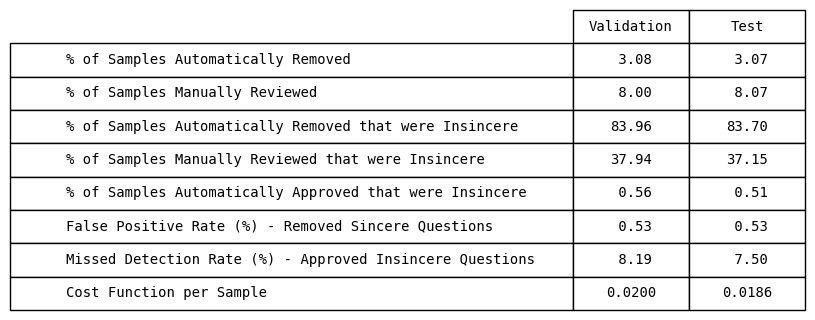

In [25]:
# Create a table of the results
data = []
for perf in [val_performance, test_performance]:
    data.append([
        f"{perf['automatic_removal_rate'] * 100:0.2f}",
        f"{perf['manually_reviewed_rate'] * 100:0.2f}",

        f"{perf['automatically_removed_insincere_proportion'] * 100:0.2f}",
        f"{perf['manually_review_insincere_proportion'] * 100:0.2f}",
        f"{perf['automatically_approved_insincere_proportion'] * 100:0.2f}",

        f"{perf['false_positive_rate'] * 100:0.2f}",
        f"{perf['missed_detection_rate'] * 100:0.2f}",
        
        f"{perf['cost_per_sample']:0.4f}",
    ])
    data[-1] = [datum.rjust(5, " ") for datum in data[-1]]
data = np.array(data).T

# Add a table at the bottom of the axes
rows = (
    f"% of Samples Automatically Removed",
    f"% of Samples Manually Reviewed",
    f"% of Samples Automatically Removed that were Insincere",
    f"% of Samples Manually Reviewed that were Insincere",
    f"% of Samples Automatically Approved that were Insincere",
    f"False Positive Rate (%) - Removed Sincere Questions",
    f"Missed Detection Rate (%) - Approved Insincere Questions",
    f"Cost Function per Sample"
)
with plt.rc_context({"font.family": 'monospace'}):
    fig = plt.figure(figsize=(3, 1.5))
    ax = plt.gca()
    ax.set_axis_off()
    plt.rcParams['font.family'] = 'monospace'
    table = ax.table(
        cellText=data,
        rowLabels=rows,
        colLabels=["Validation", "Test"],
        loc='center',
        cellLoc='center',
    )
    table.scale(xscale=1, yscale=2)
    plt.show()

### Where would we go from here?
After some back and forth with stakeholders, we could begin to add more of the complexities that we initially ignored (remove some of our initial assumptions).
* We have side-stepped the issue of long questions. As mentioned previously we truncate down to 64 tokens, so a malicious user could have the first 64 tokens worth of their question be sincere then be as insincere as they want after that. Only 0.06% of samples are longer than 64 tokens, so we could send them all to the manual review team at the initial release. This eats into our manual review resource slightly.
* We likely want to have some review process for removed questions, so users with a sincere question that got automatically removed can appeal the decision. That would eat into our manual review resources, so maybe instead of using the full 8% for initial review, we review 7.5% initially and expect the remaining resources to be used by appeals. The exact amount for initial review will be determined by the number we expect to be appealed and would turn into an optimization problem similar to the one implemented in optimize_thresholds.
* Another complexity is that manual reviewers aren't perfect labelers. When we budget for the appeal process, we should expect some appeals will come from manually reviewed questions. This will also reduce the advertised performance for both missed detection and false positive rate.
    * It begins to get difficult to measure performance when there is not a ground truth data source. We may be able to estimate the error rates of the manual review process with an analysis using a best-of-3 review committee. This could again be some continuous process that further eats into out 8% allocation.
* Another complexity is that insincereness is not the only quality used to remove questions. We would likely have multiple models flagging/removing questions for different reasons (or one model with a multi-classification problem, or perhaps multiple heads where it can rate the insincereness from 0 to 1, the profanity from 0 to 1, etc). All those models/qualities would compete for our 8% allocation.
* Another complexity is that we would want to be estimating the proportion of sincere/insincere questions sent for automatic removal and automatically approved (to monitor the model). Estimating that for automatic removal and automatic approval would also eat into our manual resource.
* The last complexity I will discuss here is that not all insincere questions are equally bad. In this experiment, questions are either insincere or not. However, we might have some cost function for different classes of insincere. Ex: Allowing a racist or homophobic question to slip through costs 1.0 while allowing a question that calls Americans loud and obnoxious costs 0.3.

Additionally, the work doesn't end with the initial release or even end with the aforementioned additional complexities. Even though the model performed well, that doesn't mean we should leave it static. We can continually improve the model based on new labels created by the manual review process. Doing so will continually improve the user experience by both removing more insincere questions and removing less sincere ones. We would limit model drift because as the input distribution changes, our model also changes. I'm sure once the model is deployed, our stakeholders will find other use cases, other metrics, other similar projects, low hanging fruit for features, and more improvements we can make that all benefit the company.